EPOCH:  0
CLASTERIZATION END Class0:  1 Class1:  999
avgFirstCluster:  1.0  avgSeccondClustoer:  0.0004837183481031746
EPOCH:  1
CLASTERIZATION END Class0:  1 Class1:  999
avgFirstCluster:  0.0003869746784825397  avgSeccondClustoer:  1.6844637874819964e-06
EPOCH:  2
CLASTERIZATION END Class0:  1 Class1:  999
avgFirstCluster:  0.0027858588272904783  avgSeccondClustoer:  1.2667913201245747e-05
EPOCH:  3
CLASTERIZATION END Class0:  1 Class1:  999
avgFirstCluster:  0.0023281766812807483  avgSeccondClustoer:  3.253605775552171e-05
EPOCH:  4
CLASTERIZATION END Class0:  1 Class1:  999
avgFirstCluster:  0.005724122814137342  avgSeccondClustoer:  0.00010194564168234729
EPOCH:  5
CLASTERIZATION END Class0:  1 Class1:  999
avgFirstCluster:  0.005835924376738932  avgSeccondClustoer:  0.00014848058341139785
EPOCH:  6
CLASTERIZATION END Class0:  1 Class1:  999
avgFirstCluster:  0.006669602199257338  avgSeccondClustoer:  0.0002719306459847387
EPOCH:  7
CLASTERIZATION END Class0:  1 Class1:  999
avgFi

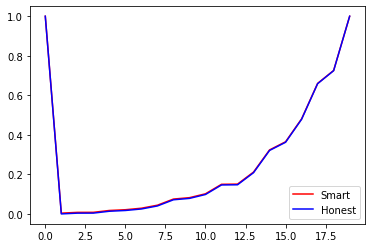

In [3]:
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np # obliczenia numeryczne
import sklearn # algorytm K-means z pakietu sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', 1000)  # or 1000
pd.set_option('display.max_rows', 1000)  # or 1000
pd.set_option('display.max_colwidth', 1000)  #

N = 1000                        #liczba agentów
S = 250                         #liczba S agentów
H = N - S;
V0 = 1                          # Vi(0) – początkowa (t = 0) miara zaufania każdego agenta. Przedział [0..1]
MAX_EPOCHES = 20#100;              # Maks cykli
S_TYPE = 'D'                    # S polityka
CONSPIRACY = False

Kmin = 5
Kmax = 15
I = random.randint(Kmin,Kmax);  #Liczba dostawców usług w trackie intereakcji

expoA = 1                       # dystrybuanta zm. losowej Aij(t):FA(a) = a^(expoA)
expoG = 10                      # dystrybuanta zm. losowej Gij(t):FG(a) = a^(expoG)

STRATEGY = 'M';

X = 1 # random.random();            # dobra wola wykazywaną przez h-politykę, 
Y =  random.random();            # dobra wola wykazywaną przez s-politykę
Z = random.random();            # dobra wola wykazywaną przez s-politykę

delta = 0.8                       # 1 lub 0.8 lub 0.6
COLLUSION = True                 # False brak zmowy ; True zmowa


AGENTS = []

def getRandomInteractedAgents(requested_agent):
    random_angents = random.sample(AGENTS, random.randint(Kmin,Kmax))
    if requested_agent in random_angents:
        return getRandomInteractedAgents(requested_agent)
    else:
        return random_angents

class Agent:
    def __init__(self, id):
        self.id = id
        self.epochV = [None] * MAX_EPOCHES
        self.epochV[0] = V0
        self.epochAvgR = [None] * MAX_EPOCHES
        self.interactedAgents = [None] * MAX_EPOCHES
        self.p = None
        self.r = None
        self.clasteristaionClass = None
        self.isSmart = False

    def getV(self, t):
        if t >= MAX_EPOCHES:
            return None
        if self.epochV[t] is not None:
            return self.epochV[t]
        else:
            raise Exception("ERROR: There is no V for ", self.id, " at epoch: ", t)

    def getAvgR(self, t):
        if self.epochAvgR[t] is not None:
            return self.epochAvgR[t]
        else:
            print("Warning AvgR is not available.", self.id, " for epoch:", t)
            return self.computeAvgR(self, t)

    def setVperEpoch(self, epoch, newV):
        if epoch >= MAX_EPOCHES or epoch <= 0:
            return;
        self.epochV[epoch] = newV;
        return;

    def getNumberOfCyclesSinceLastIntereaction(self, other, time):
        numberOfCycles = None
        for epoch in range(time+1):
            for foreignAgents in self.interactedAgents[epoch]:
                if other is foreignAgents:
                   numberOfCycles = epoch
        if numberOfCycles is None:
            return None
        else:
            return time - numberOfCycles

    def computeAvgR(self, t):
        sum = 0.0
        for foreignAgent in AGENTS:
            if foreignAgent is self:
                break
            lastInteractionWithMe = foreignAgent.getNumberOfCyclesSinceLastIntereaction(self, t)
            if lastInteractionWithMe is not None and lastInteractionWithMe <= t:
                sum += foreignAgent.getV(t) * pow(delta, lastInteractionWithMe) * self.computeR(foreignAgent, t-lastInteractionWithMe)
            else:
                break
        self.epochAvgR[t] = sum
        return sum

    def getParamP(self, other, time):
        raise Exception("ERROR: Agetn getParamP must be overriden")
    
    def getParamR(self, other, time):
        raise Exception("ERROR: Agetn getParamR must be overriden")

    def computeR(self, other, time):
        raise Exception("ERROR: Agetn computeR must be overriden") 


class Smart(Agent):
    def __init__(self, id):
        super().__init__(id)
        self.p = Y
        self.r = Z
        self.isSmart = True

    def getParamP(self, other, time):
        return self.p
    
    def getParamR(self, other, time):
        return self.r
    
    def computeR(self, other, time):
        if COLLUSION: # ZMOWA
            return 1;
        efficiency = pow(random.random(), expoG) # Gij    Gij = a^ expoG
        if STRATEGY == 'M':
            return efficiency * self.computeP(other, time) * self.getParamR(other, time)
        elif STRATEGY == 'D':
            return min(efficiency * self.computeP(other, time), self.getParamR(other, time))
        else:
            raise Exception("Unknown strategy")

    def computeP(self, other, time):
        avalibility = pow(random.random(), expoA) # Aij
        if STRATEGY == 'M':
            return avalibility * self.getParamP(other, time)
        elif STRATEGY == 'D':
            return min(avalibility, self.getParamP(other, time))
        else:
            raise Exception("Unknown strategy")


class Honest(Agent):
    def __init__(self, id):
        super().__init__(id);
        self.p = 1 if V0 >= 1 - X else 0
        self.r = 1 if V0 >= 1 - X else 0

    def getParamP(self, other, time):
        return 1 if self.epochV[time] >= 1 - X else 0
    
    def getParamR(self, other, time):
        return 1 if other.epochV[time] >= 1 - X else 0

    def computeR(self, other, time):
        efficiency = pow(random.random(), expoG) # Gij
        if other.epochV[time] >= 1 - X:
            return efficiency * self.computeP(other, time);
        else:
            return 0;

    def computeP(self, other, time):
        avalibility = pow(random.random(), expoA) # Aij
        if other.epochV[time] >= 1 - X:
            return avalibility;
        else:
            return 0;  



def performClasterization():
    dictionaryClusterization = []
    for agent in AGENTS:
        if agent.isSmart:
            dictionaryClusterization.append({"Typ": 'Smart', "Id":agent.id, "Agent": agent})
        else: 
            dictionaryClusterization.append({"Typ":"Honest", "Id":agent.id, "Agent": agent})
    # rAvgResultsLabel = ['rAvg' for agent in range(N)]
    rAvgResults = []
    label = []
    ids = []
    tmpAgents = []
    for row in dictionaryClusterization: 
        rAvgResults.append(row.get('Agent').epochAvgR[0])
        label.append(row.get('Typ'))
        ids.append(row.get('Id'))
        tmpAgents.append(row.get('Agent'))

    framedDictionary = {"Typ": label, "Agent": tmpAgents, "AgentId": ids, 'RAVG' : rAvgResults}
    df = pd.DataFrame(framedDictionary)
    scaler = StandardScaler()
    scaler.fit(df[['RAVG']])
    scaled_data = scaler.transform(df[['RAVG']])
    scaled_data_df = pd.DataFrame(data=scaled_data)
    kmeans = sklearn.cluster.KMeans(n_clusters=2).fit(scaled_data_df)
    prediction = kmeans.labels_.astype(int)
    prediction_df = pd.DataFrame(data=prediction, columns=['klasyfikacja'])
    df_full = pd.concat([df, scaled_data_df, prediction_df], axis=1)
    df_full['klasyfikacja'] = np.where(df_full['klasyfikacja']==0, 1, 0)
    
    firstClassCounter = 0;
    seccondClassCounter = 0;
    
    for index, row in df_full.iterrows():
        agent = row['Agent'];
        agent.clasteristaionClass = row['klasyfikacja']
        if row['klasyfikacja'] == 0:
            firstClassCounter+=1
        else:
            seccondClassCounter+=1

    print("CLASTERIZATION END Class0: ", firstClassCounter, "Class1: ", seccondClassCounter)
    return df_full

def computeAverage(agents, epoch):
    elements = 0.0;
    sum = 0.0;
    for agent in agents:
        sum += agent.getAvgR(epoch)
        elements += 1.0
    return sum / elements;

def computeV(agent, belongedCluster, epoch, highCluster):
    numeral = 0.0;
    numeralElements = 0.0;
    denominator = 0.0;
    denominatorElements = 0.0;

    for belongedAgent in belongedCluster:
        numeral += belongedAgent.getAvgR(epoch)
        numeralElements += 1
    for highAgent in highCluster:
        denominator += highAgent.getAvgR(epoch)
        denominatorElements += 1
    numeral /= numeralElements
    denominator /= denominatorElements
    # print("Agent id: ", agent.id, "Epoch: ", epoch, " V(epoch+1): ", numeral/denominator)
    agent.setVperEpoch(epoch+1, numeral/denominator);
    

def drawAvgTrustworh():
    smartAgents = []
    smartAgentsCounter = 0;
    honestAgents = []
    honestAgentsCounter = 0;
    
    for agent in AGENTS:
        if agent.isSmart:
            smartAgents.append(agent)
            smartAgentsCounter+=1;
        else:
            honestAgents.append(agent)
            honestAgentsCounter += 1;
        
    smartVAvgList = [];
    honestVAvgList = [];
    epochList = [];

    for epoch in range(MAX_EPOCHES):
        epochList.append(epoch)
        smartAvgV = 0.0;
        for smartAgent in smartAgents:
            smartAvgV += smartAgent.getV(epoch)
        smartVAvgList.append(smartAvgV/smartAgentsCounter);
        
        honestAvgV = 0.0;
        for honestAgent in honestAgents:
            honestAvgV += honestAgent.getV(epoch)
        honestVAvgList.append(honestAvgV/honestAgentsCounter);


    plt.plot(epochList, smartVAvgList, color='red', label='Smart')
    plt.plot(epochList, honestVAvgList, color='blue', label='Honest')
    plt.legend(loc='best')
    plt.show()
    return;

############################# MAIN #############################
counter = 0;
for smartAgent in range(S):
    newAgent = Smart(counter);
    AGENTS.append(newAgent)
    counter += 1
for honestAgent in range(H):
    newAgent = Honest(counter);
    AGENTS.append(newAgent)
    counter += 1

random.shuffle(AGENTS)

for epoch in range(MAX_EPOCHES):
    print("EPOCH: ", epoch)
    for agent in AGENTS:
        agent.interactedAgents[epoch] = getRandomInteractedAgents(agent)
    for agent in AGENTS:
        result = agent.computeAvgR(epoch)
        # if result != 0:
        #     print("Agent id: ", agent.id, " result = ", result, " epoch = ", epoch)
    
    # Compute Vi(t+1)
    df_full = performClasterization();
    fisrtCluster = []
    seccondCluster = []
    for agent in AGENTS:
        if (agent.clasteristaionClass == 0):
            fisrtCluster.append(agent)
        else:
            seccondCluster.append(agent)
    avgFirstCluster = computeAverage(fisrtCluster, epoch)
    avgSeccondClustoer = computeAverage(seccondCluster, epoch)
    clusterHigh = fisrtCluster if avgFirstCluster >= avgSeccondClustoer else seccondCluster
    clusterLow = seccondCluster if clusterHigh == fisrtCluster else fisrtCluster
    print("avgFirstCluster: ", avgFirstCluster, " avgSeccondClustoer: ", avgSeccondClustoer)

    for agentHigh in clusterHigh:
        # print("HIGH")
        computeV(agentHigh, clusterHigh, epoch, clusterHigh)
    for agentLow in clusterLow:
        # print("LOW")
        computeV(agentLow, clusterLow, epoch, clusterHigh)

    # for agent in AGENTS:
    #     print("Agent id: ", agent.id, "Epoch: ", epoch, " V(epoch+1): ", agent.getV(epoch+1))

drawAvgTrustworh()
# for agent in AGENTS:
#     print("Agent id: ", agent.id, " Classyfication: ", agent.clasteristaionClass)

# plt.plot(df_full.get('RAVG'), color='blue',label='RAVG')
# plt.show()
############################# MAIN #############################
